In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

Using TensorFlow backend.


In [4]:
from sklearn.preprocessing import StandardScaler
from keras import metrics

In [5]:
test_final = pd.read_csv('../wrangled_data/testing_post_wrangle_small.csv')
test_final = test_final.loc[:,['ID', 'shop_id', 'item_id']]

In [6]:
train = pd.read_csv('../csv_folder/sales_train.csv')
train = train.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum')
train

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22154              1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
...             .. .. .. .. ..  
59      22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[424124 rows x 34 columns]

In [7]:
train = train.stack().rename(columns={'item_cnt_day':'item_cnt_month'}).unstack().reset_index()

In [8]:
train = pd.merge(test_final, train, left_on = ['item_id','shop_id'], right_on = ['item_id','shop_id'], how='left')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [9]:
train = train.drop(columns=['ID', 'shop_id', 'item_id']).fillna(0)

In [10]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [11]:
X_train = train_scaled[:,:-1]
X_predict = train_scaled[:,1:]
y_train = train_scaled[:,-1]

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 33) (214200,) (214200, 33)


In [12]:
X_train = X_train.reshape((214200, -1, 33))
X_predict = X_predict.reshape((214200, -1, 33))
y_train = y_train.reshape((214200, -1))

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 1, 33) (214200, 1) (214200, 1, 33)


In [13]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(128, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(1))

model_lstm.compile(loss = 'mse',  # 'mean_squared_logarithmic_error', binary_crossentropy
                   optimizer = 'Adam',  # 'Nadam', 'adam', 'RMSprop', 'Ftrl', 'Adamax', 'Adagrad', 'Adadelta', 'SGD'
                   metrics = ['accuracy'])  # 'mean_tensor', 'kullback_leibler_divergence', 'mean_squared_error', 'mean_absolute_error', 'logcosh', 'cosine_proximity', 'cosine_similarity'
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            82944     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              129       
Total params: 83,073
Trainable params: 83,073
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size = 214200, epochs = 5)

Train on 214200 samples
Epoch 1/5
214200/214200 [==============================] - 3s 16us/sample - loss: 1.0686 - accuracy: 0.0000e+00
Epoch 2/5
214200/214200 [==============================] - 1s 3us/sample - loss: 0.8905 - accuracy: 0.0000e+00
Epoch 3/5
214200/214200 [==============================] - 1s 3us/sample - loss: 0.8726 - accuracy: 0.0000e+00
Epoch 4/5
214200/214200 [==============================] - 1s 3us/sample - loss: 0.8332 - accuracy: 0.0000e+00
Epoch 5/5
214200/214200 [==============================] - 1s 3us/sample - loss: 0.8738 - accuracy: 0.0000e+00


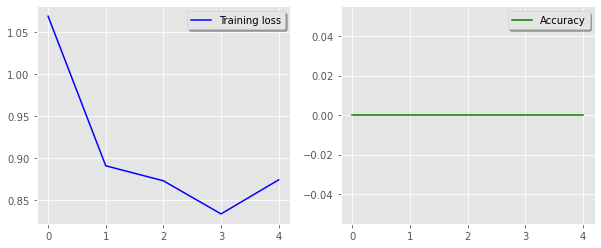

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(history_lstm.history['loss'], color='b', label="Training loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_lstm.history['accuracy'], color='g', label='Accuracy')
ax[1].legend(loc='best', shadow=True)

In [16]:
# creating submission file 
submission_pfs = model_lstm.predict(X_predict)

In [17]:
submit_scaled = np.hstack((X_predict.reshape(214200, 33), submission_pfs))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
submit = scaler.inverse_transform(submit_scaled)
submit.shape

In [ ]:
# we will keep every value between 0 and 20
submit = submit.clip(0,20)

In [ ]:
# creating dataframe with required columns 
submit = pd.DataFrame({'ID':test_final['ID'],'item_cnt_month':submit[:,-1].ravel()})
# creating csv file from dataframe
submit.to_csv('submission_files/fresh_start.csv',index = False)

In [ ]:
submit.shape, test_final.shape

In [ ]:
submit.head(3)